In [1]:
# HOME
import os
import scipy
# get the code
import sys
sys.path.append('../codeCNV')
from plot import plot_snp, plot_genomic


home = '/Users/mahtin'
home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV']['combine']
        return config
config = get_config(config_file)


cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

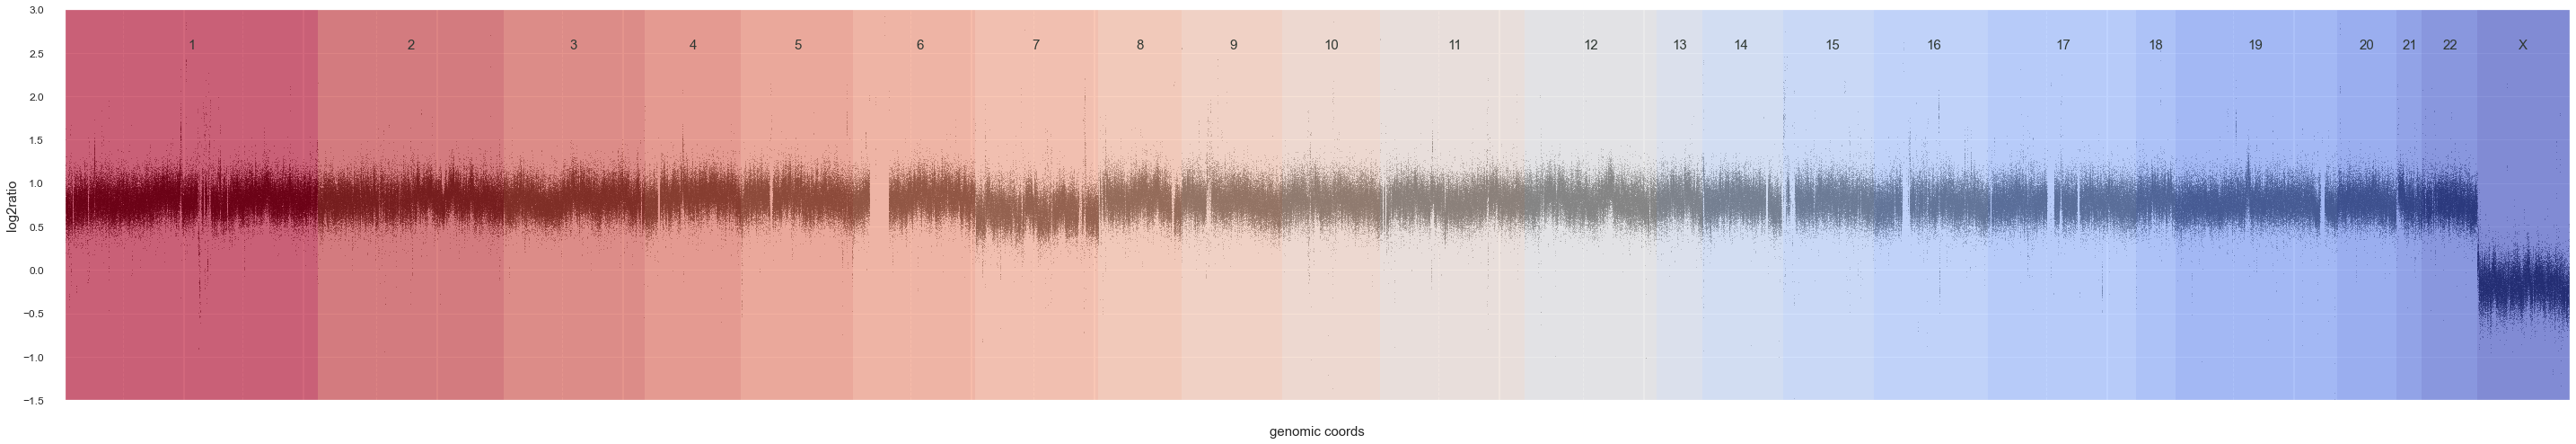

In [38]:
sample = "14_A"
cov_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.cov'), sep='\t').query('log2ratio == log2ratio')
fig_params = dict(
    figsize=(50,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-1.5,3)
)
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        ))

fig, ax, df, chrom_df = plot_genomic(cov_df.query('Coverage > 30 and PONmeanCov > 30 and PONstd < 100'), plots=[log2], chroms='all', region='', **fig_params)

In [42]:
cov_df

,Chr,Pos,FullExonPos,ExonPos,Coverage,PONmeanCov,PONmedianCov,PONstd,log2ratio
3,chr1,12750,320,320,0.013275,0.014849,0.000000,0.048672,-0.161729
4,chr1,13450,365,365,12.969301,11.607880,11.026815,4.740913,0.159996
5,chr1,13500,415,415,14.150742,15.792952,15.792952,5.716670,-0.158403
6,chr1,13550,465,465,15.031292,19.089111,20.398988,7.047795,-0.344781
7,chr1,13600,515,515,15.026867,19.209018,20.246881,7.538670,-0.354240
...,...,...,...,...,...,...,...,...,...
955496,chrX,156027400,49470607,1836144,54.156014,27.153885,26.235314,14.594739,0.995963
955497,chrX,156027450,49470657,1836194,39.345966,19.915118,19.938740,13.287676,0.982352
955498,chrX,156027800,49470677,1836214,0.632757,1.526237,1.255317,1.125031,-1.270256
955499,chrX,156027850,49470727,1836264,0.721254,2.114893,1.975640,1.572393,-1.552005


In [43]:
cov_df['PONmeanCov'].mean()

100.3620554480067

### assumption: log2ratio is normal-distributed around mean value:
+ with sigma = .2 one can approximate the center masses
+ log-likelihood should be far below average at CNV areas

mean =  0.7635303948059524


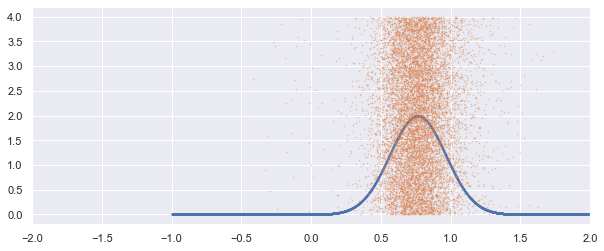

In [34]:
import numpy.random as rnd

sigma = 0.2

# get the mean of the center band
mean = df['log2ratio'].mean()
print("mean = ", mean)
def llh(data, mean, sigma):
    s = np.sqrt(2 * np.pi) * sigma
    return np.exp((data - mean)**2 / (-2*(sigma**2))) / s


r = np.linspace(-1,2,10000)

fig1, ax = plt.subplots(figsize=(10,4))
_ = ax.scatter(r, llh(r, mean, sigma), s=.2, alpha=0.5);
_ = ax.scatter(df.iloc[:10000,:]['log2ratio'], rnd.random(10000)*4, s=0.2, alpha=.5)
_ = ax.set_xlim(-2,2)

### compute the llh for center mass for entire sample
+ get the global mean
+ compute loglikelihood
+ rolling sum for chromosome

In [38]:
df.loc[:, 'llh'] = llh(df['log2ratio'], mean, sigma)


df.loc[:, 'LLH'] = df['llh'].rolling(250).sum()
df.loc[:, 'LLH'] = df['LLH'] / df['LLH'].max()

## rolling window for log2ratio
#### compute the mean for log2ratio
+ this is all done on chromosome-basis
+ the rolling should be performed on coverage data filtered for:
    * minimal coverage
    * minimal coverage in PON samples
    * maximal std of PON coverage

### test rolling_coverage

In [24]:
def interpolate(df, data_col, ref_col='FullExonPos', expand_limit=20):
    '''
    interpolates missing values in data_col using linear interpolation based on ref_col
    '''
    cols = list(df.columns)
    # set FullExonPos as index for the interpolation method to work on proper intervals
    df = df.reset_index(drop=False).set_index(ref_col, drop=False)
    df.loc[:,data_col] = df[data_col].interpolate(method='values', limit=expand_limit, limit_direction='both')
    return df.set_index('index')[cols]


def one_col_rolling(df, df_filter, col, aggr, window_size=200, expand_limit=20, normalize=False, debug=False, diff_exp=2):
    '''
    performs rolling computation of <agg> on data column <col> with given window size
    the aggregation has to be a string expression understood by the agg-function of the pandas.groupby API
    computation is performed on a left and right rolling window
    missing margins are filled by the counterpart window function
    a diff column is included ()
    
    '''
    
    org_cols = list(df.columns)
    # rolling left
    # get the right computation by passing aggr to .agg()
    # only this allows passing methods as string
    df.loc[:,'L'] = df_filter[col].rolling(window_size).agg(aggr, ddof=0)
    # rolling right by shifting the L column
    df.loc[:, 'R'] = df.shift(-window_size + 1)['L']
    
    
    col_name = col + aggr
    diff_name = col_name + "Diff"
    new_cols = org_cols +[col_name, diff_name]
    if debug:
        new_cols += [f'{col_name}L', f'{col_name}R']
    # skips interpolation if value == 0
    if interpolate:
        # interpolate missing values
        for c in ['L', 'R']:
            df = interpolate(df, c, expand_limit=expand_limit)
    # fill the margins
    L_margin = df['L'].first_valid_index()
    df.loc[:L_margin, 'L'] = df['R']
    R_margin = df['R'].last_valid_index() + 1
    df.loc[R_margin:, 'R'] = df['L']
    
    # normalize values 
    # should be only used for sum aggregations
    if normalize and aggr == 'sum':
    # normalize the data
        # print('Normalizing data')
        _min = df['L'].min()
        _max = df['L'].max()
        for c in ['L', 'R']:
            df.loc[:,c] = (df[c] - _min) / (_max - _min)
            
    # get the Diff
    df.loc[:,diff_name] = np.abs(df['R'] - df['L'])
    # normalize to max
    df.loc[:,diff_name] = df[diff_name] / df[diff_name].max()
    # here, contribution of L and R is controlled by diff value
    df.loc[:,col_name] = df['R'] * df[diff_name] + df['L'] * (1 - df[diff_name])
    
    # square the diff
    df.loc[:,diff_name] = df[diff_name] ** diff_exp
    
    # reduce to the right columns
    df = df.rename(columns=dict(L=f'{col_name}L', R=f'{col_name}R'))
    return df[new_cols]


def rolling_coverage(cov_df, config):
    '''
    cycle through the chroms and perform rolling window computations of data set in config
    '''

    # split the params dict for easier access
    params = config['coverage']
    filter_params = params['filter']
    data_params = params['data']
    # get the params for filtering
    min_cov = filter_params['min_cov']
    min_PON_cov = filter_params['min_PON_cov']
    max_PON_std = filter_params['max_PON_std']
    chrom_dfs = []
    for chrom in cov_df['Chr'].unique():
        # restrict to chrom
        chrom_df = cov_df.query('Chr == @chrom').sort_values('FullExonPos')
        # filter df
        filter_df = chrom_df.query(
            'Coverage >= @min_cov and PONmeanCov >= @min_PON_cov and PONstd < @max_PON_std')
        for data_col in data_params.keys():
            for agg in data_params[data_col].keys():
                window_size = data_params[data_col][agg]
                expand_limit = int(params['expand'] * window_size)
                # print(f"Computing rolling window for {agg} of {data_col} with window size {window_size} on {chrom}")
                chrom_df = one_col_rolling(chrom_df, filter_df, data_col, agg, 
                window_size=window_size,
                expand_limit=expand_limit, 
                normalize=params['normalize'],
                diff_exp=config['diff_exp'],
                debug=config['debug'])
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    return df

In [25]:


cov2_df = rolling_coverage(cov_df, config)
cov2_df[20:50]

,Chr,Pos,FullExonPos,ExonPos,Coverage,PONmeanCov,PONmedianCov,PONstd,log2ratio,log2ratiomean,log2ratiomeanDiff,log2ratiomeanL,log2ratiomeanR
index,,,,,,,,,,,,,
22,chr1,16750,1211,1211,82.741973,48.865664,47.685681,20.971895,0.759798,0.291209,0.0,0.291209,0.291209
23,chr1,16800,1261,1261,148.067013,93.219760,92.885703,39.309871,0.667543,0.289707,0.0,0.289707,0.289707
24,chr1,16850,1311,1311,154.872186,96.077856,96.692373,40.430913,0.688802,0.289385,0.0,0.289385,0.289385
25,chr1,16900,1361,1361,114.077061,61.665802,63.139429,25.194931,0.887466,0.289608,0.0,0.289608,0.289608
26,chr1,16950,1411,1411,80.361573,32.568064,30.704723,13.734924,1.303048,0.289123,0.0,0.289123,0.289123
27,chr1,17000,1461,1461,70.170487,22.109418,19.844533,11.001108,1.666203,0.289434,0.0,0.289434,0.289434
28,chr1,17050,1511,1511,57.239890,16.203791,14.064373,8.978232,1.820690,0.290561,0.0,0.290561,0.290561
29,chr1,17250,1574,1574,38.427551,11.966287,12.883594,5.315652,1.683165,0.293661,0.0,0.293661,0.293661
30,chr1,17300,1624,1624,47.200144,19.318562,19.355724,6.502046,1.288804,0.295541,0.0,0.295541,0.295541


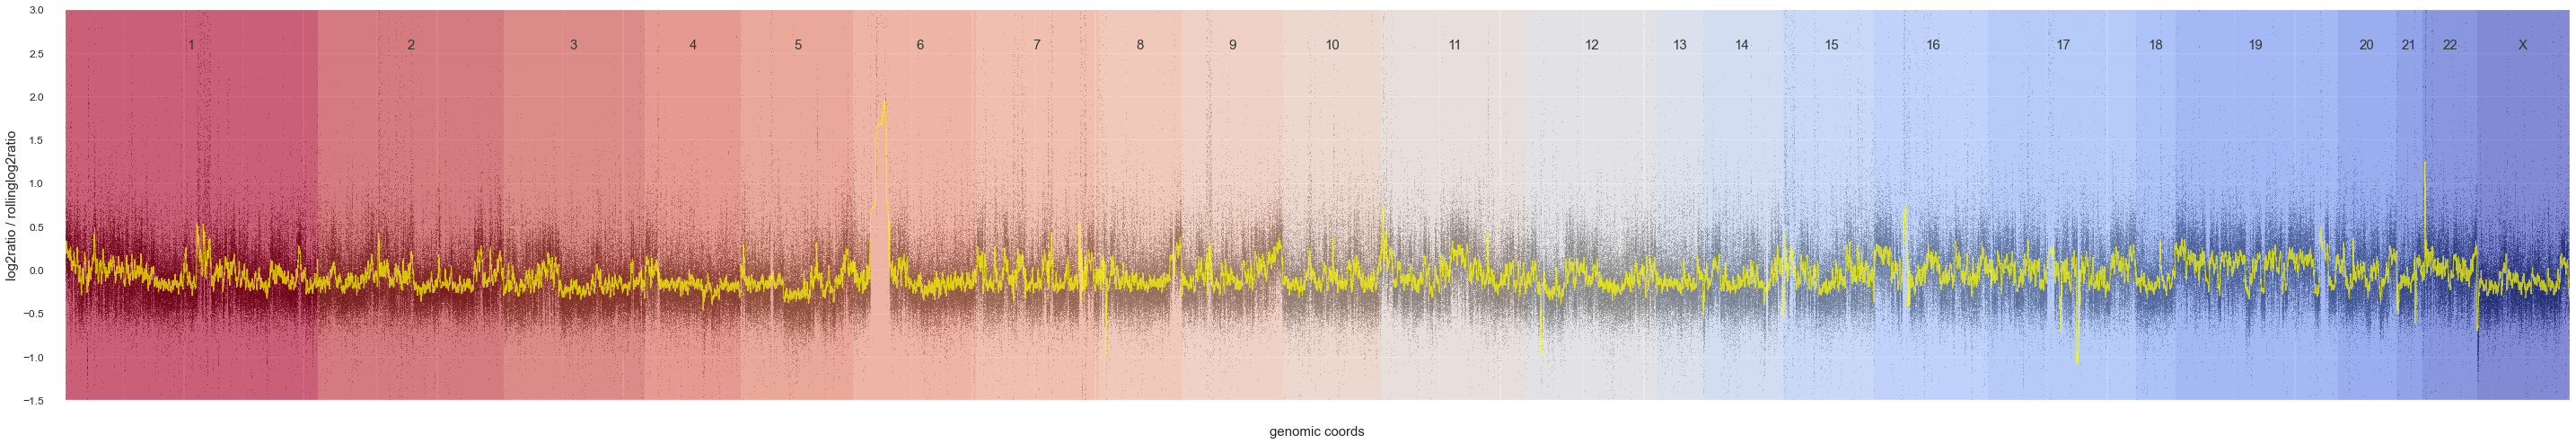

In [26]:
log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )


log2diff = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        ))

log2L = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanL',
        plot_args=dict(
            linewidth=1,
            color='white',
            alpha=.7
        ))

log2R = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanR',
        plot_args=dict(
            linewidth=1,
            color='black',
            alpha=.7
        ))

_, _, _, _ = plot_genomic(cov2_df, plots=[log2,log2mean], chroms='all', region='', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(cov2_df, plots=[log2,log2mean], chroms=chroms, region='', **fig_params)

In [ ]:
plots = [
    log2,
    log2mean,
    log2diff,
    log2L,
    log2R
]

_, _, _, _ = plot_genomic(cov2_df, plots=plots, chroms=chroms, region='chr17', **fig_params)

In [ ]:
plots = [
    log2,
    log2mean,
    log2diff,
    log2L,
    log2R
]
fig_params.update({'ylim': (-1.5,0.8)})
_, _, _, _ = plot_genomic(cov2_df, plots=plots, chroms=chroms, region=r1, **fig_params)

### test different window sizes for log2ratio

In [ ]:
plots = [
    log2,
    log2mean,
    log2diff,
    log2L,
    log2R
]

# this is only part of the config - snp config is omitted
config = {
    'debug': True, # also export the left and right rolling window values (L/R)
    'diff_exp': 4, # the exponent for the diff function --> higher values make steeper peaks
    'coverage': {
        'filter': dict(
            min_cov = 10,
            min_PON_cov = 40,
            max_PON_std = 50,
        ),
        'normalize':False,
        'expand':0.2, # after interpolation of rolling data from filtered df into full df, interpolate missing data within this fraction of window size, set 0 if no interpolation is wanted
        'data': {
            'log2ratio': {
                'mean':250
            }
        }
    }
}


cov2_df = rolling_coverage(cov_df, config)
_, _, _, _ = plot_genomic(cov2_df, plots=plots, chroms=chroms, region='chr17', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(cov2_df, plots=plots, chroms=chroms, region=r1, **fig_params)

## merge coverage data into SNP
+ reduce to important columns

In [ ]:
def interpolate_fullexonpon(merge_df):
    chrom_dfs = []
    for chrom in merge_df['Chr'].unique():
        chrom_df = merge_df.query('Chr == @chrom')
        chrom_df = interpolate(chrom_df, 'FullExonPos', ref_col='Pos', expand_limit=1000000)
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    df.loc[:, 'FullExonPos'] = df['FullExonPos'].astype(int)
    return df


def mergeSNPnCov(cov_df, snp_df):
    
    # reduce the data to important columns
    # snp
    snp_keep_cols = list(snp_df.columns)[:3] + ['Depth', 'EBscore', 'VAF']
    snp_df = snp_df.loc[:, snp_keep_cols]
    # cov
    cov_keep_cols = list(cov2_df.columns)[:4] + ['log2ratio', 'log2ratiomean', 'log2ratiomeanDiff']
    cov_df = cov_df.loc[:, cov_keep_cols]
    
    # merge the data
    merge_df = cov_df.merge(snp_df, on=list(snp_df.columns[:3]), how='outer')
    
    # interpolate FullExonPos
    merge_df = interpolate_fullexonpon(merge_df)

    # interpolate the data
    for col in [col for col in merge_df.columns if 'log2ratio' in col]:
        merge_df = interpolate(merge_df, col, expand_limit=100)
    # reduce to VAF values
    snpcov_df = merge_df.query('VAF == VAF')
    cov_df = cov_df.query('log2ratiomean == log2ratiomean')
    return snpcov_df, cov_df

In [ ]:
merge_df, _ = mergeSNPnCov(cov2_df, snp_df)
merge_df.query('FullExonPos != FullExonPos')

In [ ]:
# non-fitters are greatly reduced
merge_df.query('log2ratiomean != log2ratiomean')

### bring it all together

In [ ]:
def apply_rolling_coverage(snp_df, cov_df, config):
    '''
    master function for rolling coverage
    '''
    # reduce cov_df to valid data
    cov_df = cov_df.query('log2ratio == log2ratio')
    
    cov_df = rolling_coverage(cov_df, config)
    
    snpcov_df, rolling_cov_df = mergeSNPnCov(cov_df, snp_df)
    
    return snpcov_df, rolling_cov_df

In [ ]:
snpcov_df, rolling_cov_df = apply_rolling_coverage(snp_df, cov_df, config)

In [ ]:
snpcov_df

In [ ]:
rolling_cov_df

In [ ]:
vaf = dict(
        title='VAF',
        plot_type='scatter',   # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=5,
            alpha=1
        ))

In [ ]:
_, _, _, _ = plot_genomic(snpcov_df, plots=[log2mean, vaf], chroms=chroms, region='', **fig_params)